#Prerequisites
---

In [ ]:
# Load 3rd-party packages
!pip -q install python-Levenshtein
!pip -q install "gensim==4.3.2"
!pip -q install stanza

from collections import Counter
from itertools import compress, takewhile
from IPython.display import display
from pathlib import Path

import pandas as pd
import nltk
import numpy as np
import stanza
from gensim.models import KeyedVectors
from nltk import agreement
from nltk.corpus import wordnet
from scipy.stats import pearsonr

nltk.download('wordnet', quiet=True)

# Text preprocessing prerequisites
stanza.download("en", verbose=False)
nlp = stanza.Pipeline('en', processors='tokenize,pos', tokenize_no_ssplit=True, verbose=False, use_gpu=True)

def dictionary_analysis(text, tokens, dictionary):
  # Conducts a dictionary analysis agnostic to whether the dictionary contains words/phrases/stems
  stems = []
  words = []
  phrases = []
  for entry in dictionary:
    if " " in entry:
      phrases.append(entry)
    elif entry.endswith('*'):
      stems.append(entry[:-1])
    else:
      words.append(entry)

  word_counter = Counter(tokens)
  accumulator = 0

  for phrase in phrases:
    accumulator = accumulator + text.lower().count(phrase)

  for stem in stems:
    matches = [match for match in word_counter.keys() if match.startswith(stem)]
    for match in matches:
      accumulator = accumulator + word_counter.get(match, 0)

  for word in words:
    accumulator = accumulator + word_counter.get(word, 0)

  return accumulator

# Get GloVe files and load into gensim
!mkdir -p GloVe
!wget -q https://www.dropbox.com/s/9k39nheab1rhezq/glove.6B.50d.zip?dl=1 -O ./GloVe/glove.6B.50d.zip
!unzip -qq -n -d ./GloVe ./GloVe/glove.6B.50d.zip

glove_model = KeyedVectors.load_word2vec_format("./GloVe/glove.6B.50d.txt", binary=False, no_header=True)

print("Done with prerequisites")

In [ ]:
# Identifies all words found frequently either in at least one text or in the corpus overall
def inductive_words(tokenized_texts, threshold=3, within='text'):
  word_set = set() # A set is basically a list where there cannot be duplicate entries (as with sets in mathematics)
  if within=="text":
    for text in tokenized_texts:
      word_counter = Counter(text).most_common()
      word_set = word_set.union({token[0] for token in takewhile(lambda x: x[1] >= threshold, word_counter)})
  elif within=="corpus":
    corpus_tokens = sum(tokenized_texts, [])
    word_counter = Counter(corpus_tokens).most_common()
    word_set = {token[0] for token in takewhile(lambda x: x[1] >= threshold, word_counter)}
  return word_set

def deductive_words(basis_words):
    deductive_set = set()
    for word in basis_words:
        deductive_set.add(word)
        for sense in wordnet.synsets(word):
            while True:
                yn = input(f"Is \"{sense.definition()}\" reflective of the type of \"{word}\" you mean? (Y/N) > ")
                if yn.lower() in ('y', 'n'):
                    break
                print("Invalid response... please answer either 'y' or 'n'... \n\n")
            if yn.lower() == 'n':
                continue

            sense_name = sense.name()[0:sense.name().find(".")]
            deductive_set.add(sense_name)
            if sense_name in glove_model:
                for glove_syn, _ in glove_model.most_similar(positive=[sense_name], topn=15):
                    deductive_set.add(glove_syn)

            for synonym in sense.lemmas():
                synonym_name = synonym.name().lower().replace("_", " ")
                deductive_set.add(synonym_name)
                if synonym_name in glove_model:
                    for glove_syn, _ in glove_model.most_similar(positive=[synonym_name], topn=15):
                        deductive_set.add(glove_syn)

            for hyponym in sense.hyponyms():
                hyponym_name = hyponym.name()[0:hyponym.name().find(".")].lower().replace("_", " ")
                deductive_set.add(hyponym_name)
        print("---")

    if sum([1 for word in basis_words if word in glove_model]) == len(basis_words):
        for glove_syn, _ in glove_model.most_similar(positive=basis_words, topn=30):
            deductive_set.add(glove_syn)

    return list(deductive_set)

# Your Initial Setup
In this cell, you should enter your assignment initial setup

---

## Load your texts
In this cell, add your 'texts' for analysis. This may be the same sample of texts you used in last week's assignment, or a different set of texts created specifically for this week.

For each text add a new line with format as follows: `texts.append("""Your text here""")`. There should be one texts.append() line per text.

*If you're familiar with python you can import the texts directly using the mechanism of your choice - just make sure you load them into a list called `texts`*

In [ ]:
texts = []
texts.append("""This is a text. It is a wonderful text. Replace this text with your source text and add at least 9 others""")

## Preprocess your texts
We're going to use Stanza to preprocess the texts. Run this code unchanged after loading your texts.

In [ ]:
preprocessed_texts = []
for text_id, text in enumerate(texts, start=1):
    tokens = [word.text.lower() for sentence in nlp(text).sentences for word in sentence.words if word.upos not in ["PUNCT", "SYM", "NUM", 'X']]
    preprocessed_texts.append({'text_id': text_id, 'text': text, 'tokens': tokens})
preprocessed_df = pd.DataFrame(preprocessed_texts).set_index('text_id')

print("Here are your preprocessed texts: ")
display(preprocessed_df.head())

## Your Construct

Give your construct a name, definition, and variable name.

For the variable name, try to keep it short, all lower case, and have no spaces and symbols other than '_' in it. For instance "Innovation Orientation" might be `innov_orient`

In [ ]:
construct_name = "Construct Name Goes Here"
construct_definition = "Construct Definition Goes Here"
construct_variable = "const_var_name"

# Creating a dictionary

---

## Inductive word list generation

Set the minimum threshold for the inductive word list generator and choose either 'corpus' or 'text'.

In [ ]:
threshold = 3
within = "corpus" # can be "corpus" or "text"

# Don't change below this line--------------
inductive_list = inductive_words(preprocessed_df['tokens'], threshold, within)

print(f"Inductive list of {len(inductive_list)} words used {threshold}+ "\
      f"times (based on {within} frequency): {sorted(inductive_list)}")

## Deductive word list generation

Choose at least 3 words from which to generate synonyms for your construct and place them in the `basis_words` list. This should be of format: `basis_words = ['word', 'word', 'word']` where you replace the `word`s with your word

In [ ]:
basis_words = ['word', 'word', 'word']

# Do not change below this line------------------
for word in basis_words:
    if len(wordnet.synsets(word)) == 0:
        print(f"Word: {word} isn't in our thesaurus, use another for the purposes of this assignment")
        break
deductive_list = deductive_words(basis_words)

print(f"Deductive list of {len(deductive_list)} words: {sorted(deductive_list)}")

## Combine word lists for evaluation

Now, Python will generate an evaluation form for you to use with your judges... This will be accessible in the Files tab on the left side of the screen:

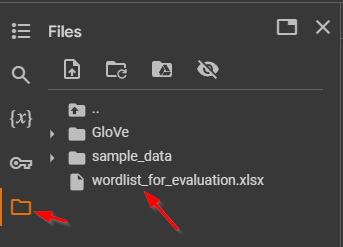

Download this and have 2 judges evaluate the words for your word list - remember... training is key (from last week)

In [ ]:
# No need to change this cell
eval_wordlist = sorted(set(list(deductive_list)+list(inductive_list)))
print(f"Here is your list of words for evaluation: {eval_wordlist}")
print("It is also being saved as wordlist_for_evaluation.xlsx")

prompt = f"Is this word reflective of {construct_name}, defined as '{construct_definition}'? 1 for yes, 0 for no."
eval_df = pd.DataFrame([(word,"","", prompt) for word in eval_wordlist], columns=("word", "coder1", "coder2", "prompt"))

eval_df.to_excel("wordlist_for_evaluation.xlsx", index=False)

## Interrater Agreement

Upload the judged Excel worksheet as "evaluated_wordlist.xlsx" to the same place you downloaded the wordlist for evaluation above. Remember, the judges entries all need to be zeroes (0) or ones (1)

In [ ]:
# Don't change anything here---------------------
evaluated_path = Path.cwd()/"evaluated_wordlist.xlsx"
if not evaluated_path.exists():
    print("uh oh... can't find the file, did you upload it and name it exactly: evaluated_wordlist.xlsx ???")
else:
    evaluated_df = pd.read_excel("evaluated_wordlist.xlsx")

words = evaluated_df['word'].tolist()
coder_1 = evaluated_df['coder1'].tolist()
coder_2 = evaluated_df['coder2'].tolist()
formatted_codes = [(1,word_num,coder_1[word_num]) for word_num in range(len(coder_1))] + \
                  [(2,word_num,coder_2[word_num]) for word_num in range(len(coder_2))]
ira_annotator = agreement.AnnotationTask(data=formatted_codes)

print("Your interrater reliability scores: ")
print(f"Percentage Agreement: {ira_annotator.avg_Ao():.2}")
print(f"Cohen's Kappa:        {ira_annotator.kappa():.2}")
print(f"Krippendorff's Alpha: {ira_annotator.alpha():.2}")

## Your evaluated word list

Below is the list of words that:
* At least one of the judges agreed upon (liberal)
* Both of the judges agreed upon (conservative)
* they disagreed upon (the list you might have the judges re-evaluate together if doing this in a real study)

In [ ]:
include_disagreements = [a | b for a,b in zip(coder_1, coder_2)]
print(f"The liberal (inclusive) word list is:\n{list(compress(words, include_disagreements))}\n\n")

exclude_disagreements = [a & b for a,b in zip(coder_1, coder_2)]
print(f"The conservative (exclusive) word list is:\n{list(compress(words, exclude_disagreements))}\n\n")

disagreements = [a ^ b for a,b in zip(coder_1, coder_2)]
print(f"The list of words disagreed upon is:\n{list(compress(words, disagreements))}")

In [ ]:
while True:
    list_selection = input("Which list would you like to proceed with: 'L' for liberal or 'C' for conservative? > ")
    if list_selection.lower() == 'l':
        final_wordlist = list(compress(words, include_disagreements))
        break
    elif list_selection.lower() == 'c':
        final_wordlist = list(compress(words, exclude_disagreements))
        break
    print("Invalid selection. Choose either \"L\" or \"C\"\n\n")

print("Great here is your final word list:")
for word in final_wordlist:
    print(f"\t{word}")


# Validity/Reliability Checks

---

Typically you would do systematic validation and reliability checks, but for this assignment, we're going to do just a few subjective evaluations for a lack of validation data.

In [ ]:
flat_corpus = []
for tokens in preprocessed_df['tokens'].tolist():
    flat_corpus.extend(tokens)

from nltk.text import Text
nltk_text = Text(flat_corpus)
final_wordlist.append("replace")
final_wordlist.append("text")

i=0
for dict_word in final_wordlist.copy():
    if dict_word in flat_corpus:
        i += 1
        while True:
            print(f"The wordlist word '{dict_word}' appears in the sample of texts. Here are the first few instances: ")
            print("-"*30)
            nltk_text.concordance(dict_word)
            valid_usage = input("\nDoes this word appear to be consistently used in-context for your construct? (Y/N) > ")
            if valid_usage.lower() in ('y','n'):
                break
            print("Invalid entry, choose either \"Y\" or \"N\"\n\n")
        if valid_usage.lower() == 'n':
            print(f"\nRemoving '{dict_word}' from the wordlist")
            final_wordlist.remove(dict_word)
        print("\n\n")
    if i >= 10:
        break

if i == 0:
    print("None of your wordlist words appeared in your sample of texts... your dictionary analysis is going to have no variance.")
else:
    print("Abbreviated concordance analysis complete!")

Sometimes in the evaluation process you need to add words, phrases or stems to the word list. Are there words/stems/phrases you would want to add to this list that weren't uncovered in the original process?

Remember:
* Words are just in quotes: "word"
* Phrases have spaces in them and are in quotes: "this is a phrase"
* Stems are like words, but end in an asterisk: "ste*"

Replace the list below with your words, stems, and phrases:

In [ ]:
add_these = ["word", "ste*", "this is a phrase"]

# Don't change below this line--------------------
final_wordlist.extend(add_these)
final_wordlist = list(set(final_wordlist))

# Dictionary Analysis

---

With a dictionary in hand, you can now run your dictionary analysis. Run the code below and obtain the final dictionary analysis in the files menu to the left.

In [ ]:
preprocessed_df[construct_variable] = preprocessed_df.apply(lambda x: dictionary_analysis(x['text'], x['tokens'], final_wordlist), axis=1)
preprocessed_df["text_length"] = preprocessed_df.apply(lambda x: len(x['tokens']), axis=1)
preprocessed_df[f'dlnorm_{construct_variable}'] = preprocessed_df[construct_variable] / preprocessed_df["text_length"]
preprocessed_df[["text_length", "text", construct_variable, f"dlnorm_{construct_variable}"]].to_excel("final_dictionary_analysis.xlsx")

That's the end of the workbook - proceed back to the assignment for details regarding the write-up.